In [1]:


#Std. imports
import os
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.animation as anim
from matplotlib.gridspec import GridSpec
from scipy.special import lambertw
from copy import deepcopy
from labellines import labelLines
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pprint
import networkx as nx
import pytest

from IPython.display import display, HTML

# Useful Functions/Constants
from src.data.species import *
from src.structs.gas import *
from src.utils.newton import *
from src.structs.assembly import Assembly
from src.structs.element import Element
from src.structs.option import Option
from src.elements.compressor import *
from src.structs.ports.shaftport import ShaftPort
from src.utils.compressible import *
from src.data.constants import *

In [2]:
Dtest = Dm(1)
M = MfromD(Dtest, supersonic=False)
print(M)

0.9999923706054688


In [3]:

gas = Gas(Air, 298.15, 100000)
print(gas.h, " ", gas.s, " ", gas.T, " ", gas.P, " ", gas.cp)
print(np.round(gas.h * gas.species.molecweight / (1000**2),3))

-4333.765858823373   6867.889852784657   298.15   100000   1004.7134758645861
-0.126


In [4]:
gas.set_h(-1000)
print('')
print(gas.h, " ", gas.s, " ", gas.T, " ", gas.P, " ", gas.cp)


[-999.73227528]   [6879.01048765]   [301.46812595]   100000   [1004.87606009]


/home/girouxw/pyCFlow/src/utils/newton.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'xs': np.array(xs),


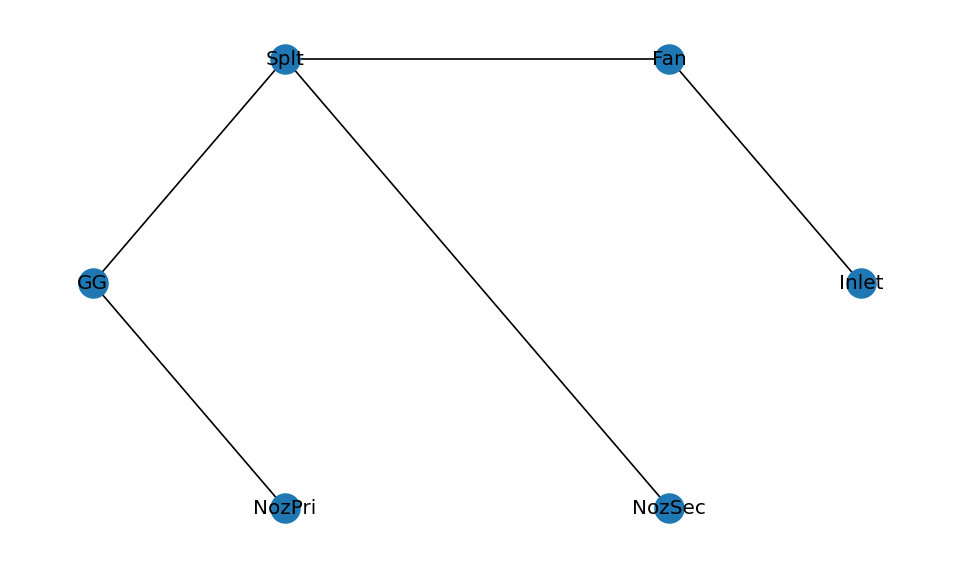

In [5]:
Inlet = Element('Inlet')
Inlet.ports['Fl_I'] = 'Fl_I'
Inlet.ports['Fl_O'] = 'Fl_O'

Fan = Element('Fan')
Fan.ports['Fl_I'] = 'Fl_I'
Fan.ports['Fl_O'] = 'Fl_O'

Splt = Element('Splt')
Splt.ports['Fl_I'] = 'Fl_I'
Splt.ports['Fl_O1'] = 'Fl_O1'
Splt.ports['Fl_O2'] = 'Fl_O2'

GG = Element('GG')
GG.ports['Fl_I'] = 'Fl_I'
GG.ports['Fl_O'] = 'Fl_O'

NozSec = Element('NozSec')
NozSec.ports['Fl_I'] = 'Fl_I'
NozSec.ports['Fl_O'] = 'Fl_O'

NozPri = Element('NozPri')
NozPri.ports['Fl_I'] = 'Fl_I'
NozPri.ports['Fl_O'] = 'Fl_O'

Eng = Assembly('Eng')
Eng.add_element(Inlet)
Eng.add_element(Fan)
Eng.add_element(Splt)
Eng.add_element(GG)
Eng.add_element(NozPri)
Eng.add_element(NozSec)

Eng.add_linkage('Inlet', 'Fl_O' , 'Fan'    , 'Fl_I', 'F020')
Eng.add_linkage('Fan'  , 'Fl_O' , 'Splt'   , 'Fl_I', 'F021')
Eng.add_linkage('Splt' , 'Fl_O1', 'GG'     , 'Fl_I', 'F022')
Eng.add_linkage('GG'   , 'Fl_O' , 'NozPri' , 'Fl_I', 'F090')
Eng.add_linkage('Splt' , 'Fl_O2', 'NozSec' , 'Fl_I', 'F190')

Eng.connectGraph.graph

fig, ax = plt.subplots(figsize=(10,6), dpi=120)
nx.draw_circular(Eng.connectGraph, with_labels=True)

In [6]:
comp = Compressor('comp')
print(comp.Fl_I.Tt, " ", comp.Fl_I.ht)
# comp.Fl_I.Tt
print(comp.Fl_I.Tt, " ", comp.Fl_I.ht)

298.15   -4333.765858823373
298.15   -4333.765858823373


In [11]:
testFlow = FlowStation('test', species=Air)

testFlow.MN = .6
testFlow.mdot = 200

testFlow.setTotal_TP(400, 1e6)

print(testFlow.A)

# print(testFlow.gt, " ", testFlow.gs)

# print(testFlow.Pt/testFlow.Ps)

0.1177638133295138


In [17]:
testFlow_copy = deepcopy(testFlow)

In [18]:
print(testFlow.Tt)
print(testFlow_copy.Tt)

testFlow_copy.setTotal_TP(600, 1e6)
print()

print(testFlow.Tt)
print(testFlow_copy.Tt)

400
400

400
600
